### **ATOC 4500 Data Science Lab: Final Project**

**Determining Seasonality and Statistical values using data from Wellington, New Zealand and the ENSO index for years 2016 to 2022**

Author: Victoria Chavez, vich9969@colorado.edu

Last updated: April 27,2022

**>>>>This code is available on github at
 https://github.com/VMChavez1/ATOC4500_Chavez_Finalproject.git**  

**>>>>NOTE: Please run this and other notebooks using a Chrome browser**

**Introduction:**

I will be looking at data from the airport in Wellington, New Zealand to determine two hypotheses:

**Hypothesis 1: There will be a strong Spring signal in the data using the 3 cluster method**

**Hypothesis 2: Dry temperature will have a stong positive correlation with the ENSO index (above .5) and there is statistical significance between dry temperature and the ENSO index**

**Motivation:**

After doing some research over the summer on Argentina I know that they have very strong Spring storms partially due to the mountains but none the less a strong Spring storms. I did not evaluate data from Argentina using the clustering method but would assume due to the strong srping storms they would have a defined cluster. I want to determine if New Zealand has climate similarities to Argentina even though they are about 10 degrees further South. I will use the clustering method to determine if New Zealand has a strong Spring signal and if it shows up best using the 3 or 4 cluster method. I would also like to see if there is a correlation in the observed variables in New Zealand with the ENSO index. ENSO affects the entire world climate mostly when there is an El Nino, so I am hoping to find a variable/s that have a strong positive correlation so I will use Linear Regression to determine this and I will use a T-test to determine if there is statistical significance between dry temperature and ENSO index. 

**Citations:**

https://www.ncei.noaa.gov/metadata/geoportal/rest/metadata/item/gov.noaa.ncdc:C00684/html

https://www.newzealand.com/us/seasons-in-new-zealand/

https://github.com/jenkayco/ATOC4500_Spring2022.git



**Note: This will be done in 2 parts**

# **PART 1: Clustering**

# **STEP 1: Import packages and Read in data**

In [1]:
### import packages
import pandas as pd
import numpy as np
import datetime
import time
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from dateutil import relativedelta
import csv
from scipy import stats
from matplotlib import rcParams
from sklearn import linear_model
from sklearn import metrics
from google.colab import files
from scipy.cluster.vq import vq, kmeans, whiten
import matplotlib.pyplot as plt

In [2]:
### upload file NZ_hourlydata_munged.csv
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))#

Saving NZ_hourlydata_munged.csv to NZ_hourlydata_munged.csv
User uploaded file "NZ_hourlydata_munged.csv" with length 7662698 bytes


In [3]:
### Read in data
df = pd.read_csv("NZ_hourlydata_munged.csv")
### Preview the values in the data frame by printing it
print(df)
### Print the Shape of the data frame
print(df.shape)

                       DATE             datetime  drytemp_F  dewtemp_F  \
0       2016-01-01T00:00:00  2016-01-01 00:00:00       59.0       54.0   
1       2016-01-01T00:30:00  2016-01-01 00:30:00       57.0       52.0   
2       2016-01-01T01:00:00  2016-01-01 01:00:00       57.0       52.0   
3       2016-01-01T01:30:00  2016-01-01 01:30:00       59.0       54.0   
4       2016-01-01T02:00:00  2016-01-01 02:00:00       57.0       54.0   
...                     ...                  ...        ...        ...   
105756  2022-01-01T21:30:00  2022-01-01 21:30:00       64.0       59.0   
105757  2022-01-01T22:00:00  2022-01-01 22:00:00       64.0       59.0   
105758  2022-01-01T22:30:00  2022-01-01 22:30:00       63.0       59.0   
105759  2022-01-01T23:00:00  2022-01-01 23:00:00       63.0       59.0   
105760  2022-01-01T23:30:00  2022-01-01 23:30:00       61.0       59.0   

        prec_inch    RH  pres_mbar   wdir  wspd_mph  wgust_mph  
0             NaN  82.0        NaN   20.0     

# **STEP 2: Munge Data**

Data was recorded every 30 minutes. I want to look at the noon hour for clustering so I need to pull out all the data for noon, I then need to define seasons and add it to my dataframe, I need to check that there is no missing data and if there is it will be replaced with the mean, finally I need to whitten and scale my data to plot it. 

**Pull out noon data**

In [4]:
#### Select the time, since data was taken every 30 minutes we need hour and minutes

selectdf1 = df[pd.DatetimeIndex(df['datetime']).hour==12] ## noon
selectdf2 = selectdf1[pd.DatetimeIndex(selectdf1['datetime']).minute==00] ## noon

selectdf2

,DATE,datetime,drytemp_F,dewtemp_F,prec_inch,RH,pres_mbar,wdir,wspd_mph,wgust_mph
24,2016-01-01T12:00:00,2016-01-01 12:00:00,66.0,52.0,NaN,60.0,NaN,190.0,10.0,28.0
72,2016-01-02T12:00:00,2016-01-02 12:00:00,64.0,64.0,NaN,100.0,NaN,120.0,1.0,28.0
121,2016-01-03T12:00:00,2016-01-03 12:00:00,59.0,59.0,NaN,100.0,NaN,200.0,13.0,46.0
170,2016-01-04T12:00:00,2016-01-04 12:00:00,59.0,45.0,NaN,59.0,NaN,170.0,23.0,28.0
219,2016-01-05T12:00:00,2016-01-05 12:00:00,61.0,48.0,NaN,63.0,NaN,170.0,10.0,36.0
...,...,...,...,...,...,...,...,...,...,...
105543,2021-12-28T12:00:00,2021-12-28 12:00:00,68.0,63.0,NaN,83.0,NaN,360.0,11.0,31.0
105592,2021-12-29T12:00:00,2021-12-29 12:00:00,64.0,54.0,NaN,68.0,NaN,160.0,15.0,31.0
105641,2021-12-30T12:00:00,2021-12-30 12:00:00,70.0,52.0,NaN,53.0,NaN,350.0,21.0,31.0
105689,2021-12-31T12:00:00,2021-12-31 12:00:00,72.0,54.0,NaN,53.0,NaN,330.0,13.0,31.0


**Define Seasons and add it to dataframe**

In [5]:
## Define seasons and add it to the dataframe

## this variable contains the season defined traditionally based on the month for Southern Hemisphere: 
## DJF=summer, MAM=fall, JJA=winter, SON=spring

#1) use a dictionary to define seasons from months
#define the seasons as DJF=summer=1, MAM=fall=2, JJA=winter=3, SON=spring=4

seasons = {(1, 12, 2): 1, (3, 4, 5): 2, (6, 7, 8): 3, (9, 10, 11): 4}
## define a function to assign seasons to months using the dictionary
def season(ser):
    for k in seasons.keys():
        if ser in k:
            return seasons[k]

# 2) apply the function season to all times in my dataset
selectdf2['season']=[season(month) for month in pd.DatetimeIndex(selectdf2['datetime']).month]

## check the data frame to see if there is a new variable called "season"
selectdf2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,DATE,datetime,drytemp_F,dewtemp_F,prec_inch,RH,pres_mbar,wdir,wspd_mph,wgust_mph,season
24,2016-01-01T12:00:00,2016-01-01 12:00:00,66.0,52.0,NaN,60.0,NaN,190.0,10.0,28.0,1
72,2016-01-02T12:00:00,2016-01-02 12:00:00,64.0,64.0,NaN,100.0,NaN,120.0,1.0,28.0,1
121,2016-01-03T12:00:00,2016-01-03 12:00:00,59.0,59.0,NaN,100.0,NaN,200.0,13.0,46.0,1
170,2016-01-04T12:00:00,2016-01-04 12:00:00,59.0,45.0,NaN,59.0,NaN,170.0,23.0,28.0,1
219,2016-01-05T12:00:00,2016-01-05 12:00:00,61.0,48.0,NaN,63.0,NaN,170.0,10.0,36.0,1
...,...,...,...,...,...,...,...,...,...,...,...
105543,2021-12-28T12:00:00,2021-12-28 12:00:00,68.0,63.0,NaN,83.0,NaN,360.0,11.0,31.0,1
105592,2021-12-29T12:00:00,2021-12-29 12:00:00,64.0,54.0,NaN,68.0,NaN,160.0,15.0,31.0,1
105641,2021-12-30T12:00:00,2021-12-30 12:00:00,70.0,52.0,NaN,53.0,NaN,350.0,21.0,31.0,1
105689,2021-12-31T12:00:00,2021-12-31 12:00:00,72.0,54.0,NaN,53.0,NaN,330.0,13.0,31.0,1


**Select variables of interest**

In [6]:
## Select variables of interest, leaving out prec_inch and pres_mbar since there was no data collected for these variables.

included_cols = ['drytemp_F','dewtemp_F','RH','wdir','wspd_mph','wgust_mph'] 

## convert to a numpy array for model input and leave out the time dimensions day & hour, prec_inch, and pres_mbar.
data = selectdf2.loc[:,selectdf2.columns.isin(list(included_cols))].to_numpy()

## check the shape of your data:
print(f'Your data are now 2181 observations over 6 variables: {np.shape(data)}')


Your data are now 2181 observations over 6 variables: (2181, 6)


**Using Quick plots to check data**

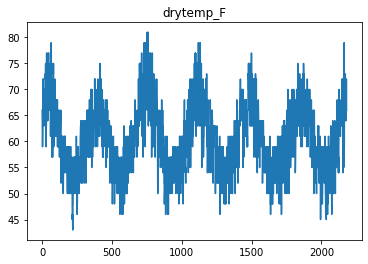

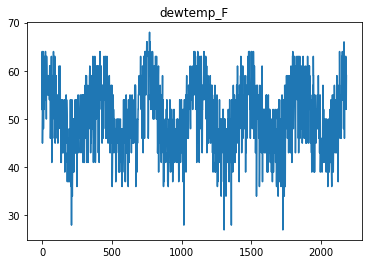

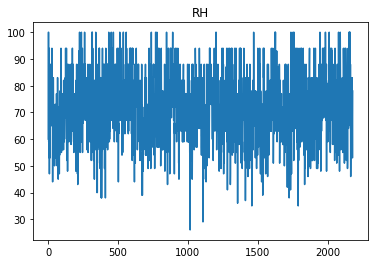

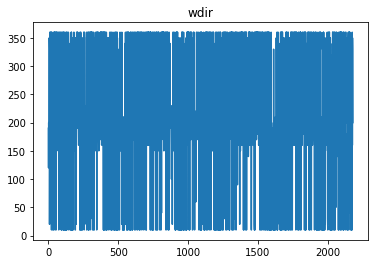

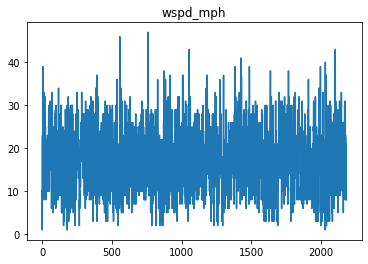

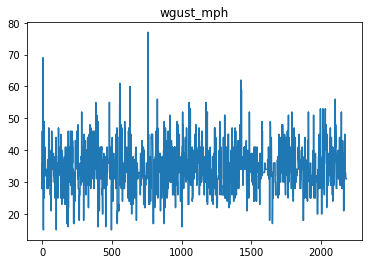

In [7]:
### option to check out quick plots of your data...
### say yes first time through - double check your input, ALWAYS.
quickplot = 'yes'
if quickplot == 'yes':
  ## Quick plots of your data
  for i in np.arange(0,np.shape(data)[1]):
    plt.plot(data[:,i]);
    plt.title(included_cols[i])
    plt.show()

**Find the mean of the data**

In [8]:
## for reference: here is an example of using np.nanmean to take the mean of a 
## numpy array and exclude missing values
print(f'take the mean exluding missing data: {np.nanmean(data)}')
print(f'take the mean of all data: {np.mean(data)}')
## Looks like no missing data since both means are the same, I will run a loop in the next cell to ensure there is no missing data

take the mean exluding missing data: 75.92022008253095
take the mean of all data: 75.92022008253095


**Check for no missing data and replace it with the mean**

In [9]:
### deal with missing data

## copy the data array into a new array without missing values called (data_nomissing)
data_nomissing=data.copy();
print(data_nomissing.shape)

option_missing='option2'

##### OPTION #1 = replace the NaN data with the mean value over the entire dataset.  Simple!
if option_missing=='option1':
  data_nomissing[:,0]=np.where(np.isnan(data[:,0])==True,np.nanmean(data[:,0]),data[:,0])
  data_nomissing[:,1]=np.where(np.isnan(data[:,1])==True,np.nanmean(data[:,1]),data[:,1])
  data_nomissing[:,2]=np.where(np.isnan(data[:,2])==True,np.nanmean(data[:,2]),data[:,2])
  data_nomissing[:,3]=np.where(np.isnan(data[:,3])==True,np.nanmean(data[:,3]),data[:,3])
  data_nomissing[:,4]=np.where(np.isnan(data[:,4])==True,np.nanmean(data[:,4]),data[:,4])
  data_nomissing[:,5]=np.where(np.isnan(data[:,5])==True,np.nanmean(data[:,5]),data[:,5])
  data_nomissing[:,6]=np.where(np.isnan(data[:,6])==True,np.nanmean(data[:,6]),data[:,6])

##### OPTION #2
if option_missing=='option2':
## replace the NaN data with the mean value for that season.  Simple!
  season =selectdf2['season'];
  print(len(season))

  ## this is the actual season from the definition in the season dictionary above
  season_idx=selectdf2['season'][pd.DatetimeIndex(selectdf2['datetime']).hour==12].to_numpy()
  #print(season_idx.shape)
  ## find all of the days in summer, i.e., where season_idx=1
  summeridx=np.nonzero(np.where(season_idx==1,1,0))
  ## loop over variables
  for i in np.arange(0,len(included_cols)):
    data_nomissing[summeridx,i]=np.where(np.isnan(data[summeridx,i])==True,np.nanmean(data[summeridx,i]),data[summeridx,i])
  ## find all of the days in fall, i.e., where season_idx=2
  fallidx=np.nonzero(np.where(season_idx==2,1,0))
  ## loop over variables
  for i in np.arange(0,len(included_cols)):
    data_nomissing[fallidx,i]=np.where(np.isnan(data[fallidx,i])==True,np.nanmean(data[fallidx,i]),data[fallidx,i])
  ## find all of the days in winter, i.e., where season_idx=3
  winteridx=np.nonzero(np.where(season_idx==3,1,0))
  ## loop over variables
  for i in np.arange(0,len(included_cols)):
    data_nomissing[winteridx,i]=np.where(np.isnan(data[winteridx,i])==True,np.nanmean(data[winteridx,i]),data[winteridx,i])
  ## find all of the days in spring, i.e., where season_idx=4
  springidx=np.nonzero(np.where(season_idx==4,1,0))
  ## loop over variables
  for i in np.arange(0,len(included_cols)):
    data_nomissing[springidx,i]=np.where(np.isnan(data[springidx,i])==True,np.nanmean(data[springidx,i]),data[springidx,i])
##Check mean of data_nomissing, looks the same as above which confirms there was no missing data. No need to quick plot again.
print(np.mean(data_nomissing))

(2181, 6)
2181
75.92022008253095


**Rescale and whiten data**

In [10]:
##Rescale the data by whitening it for clustering
## https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.vq.whiten.html
#"Before running k-means, it is beneficial to rescale each feature dimension of the observation 
#set by its standard deviation (i.e. “whiten” it - as in “white noise” where each frequency has equal power). 
#Each feature is divided by its standard deviation across all observations to give it unit variance."
scaled_data = whiten(data_nomissing) # sci-kit learn's function to standardize data in the clustering toolbox
#scaled_data = data.copy() # uncomment to NOT whiten, but still enable this notebook to run without modifications

print('mean of each variable')
print(np.mean(scaled_data,axis=0))
print('standard deviation of each variable')
print(np.std(scaled_data,axis=0))

mean of each variable
[9.0699836  7.68610285 5.75692329 1.79174784 2.34677985 5.08663278]
standard deviation of each variable
[1. 1. 1. 1. 1. 1.]


**Use Quick plots to check data one more time before clustering**

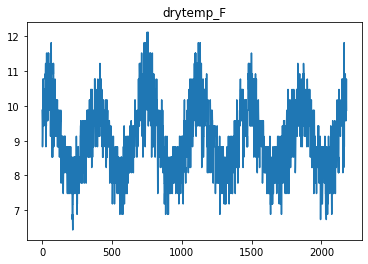

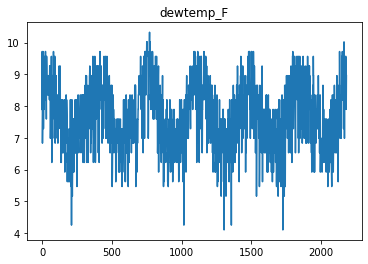

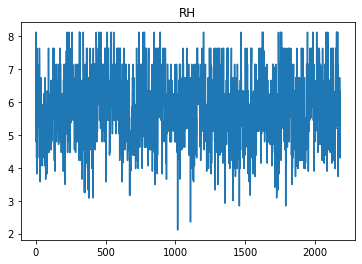

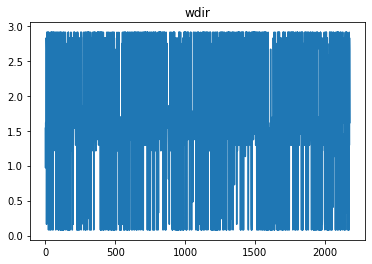

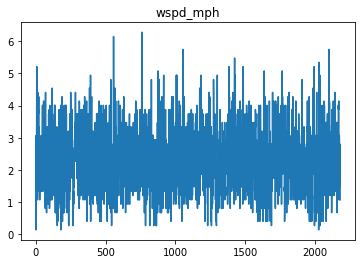

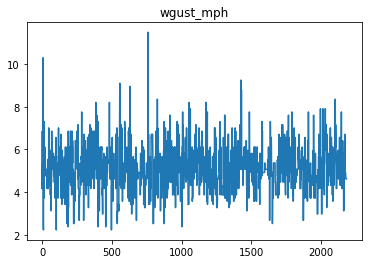

In [11]:
## check out quick plots of scaled_data... always take this option.
## note: we did not remove the mean...
quickplot = 'yes'
if quickplot == 'yes':
  ## Quick plots of your data
  for i in np.arange(0,np.shape(scaled_data)[1]):
    plt.plot(scaled_data[:,i],label=included_cols[i]);
    ## check what happens when you uncomment the two lines below
    plt.title(included_cols[i])
    plt.show()
  #plt.legend()

# **STEP 3: Apply Data Science Method**

**Using 4 Cluster method**

In [47]:
## select the number of clusters 
NO_CLUSTERS = 4 # use 4 clusters - see if you get out 4 seasons of winter, fall, spring, summer

## do the clustering, return centroids (i.e., Coordinates of cluster centers.)
## https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
## https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.vq.kmeans.html
centroids, _  = kmeans(scaled_data,NO_CLUSTERS,iter=20)

In [48]:
## find an index (idx) that is the label for each value in your dataset (i.e, each day at noon)
## https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.vq.vq.html
idx, _ = vq(scaled_data,centroids) # vq returns cluster idx for each observation

## add 1 so that idx is also 1-based like df['season']
idx=idx+1

print('Here is the cluster idx for each day of the year:') 
print(idx.shape) # prints K-mean's season label for each day

Here is the cluster idx for each day of the year:
(2181,)


# **STEP 4: Present results visually**

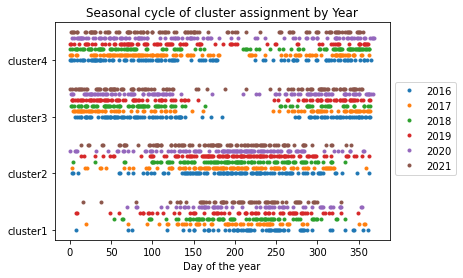

In [49]:
### Make a quick plot to show the index results

### plot each year
plt.plot(idx[0:366],'.',label='2016');
plt.plot(idx[365:365*2]+0.1,'.',label='2017');
plt.plot(idx[365*2:365*3]+0.2,'.',label='2018');
plt.plot(idx[365*3:365*4]+0.3,'.',label='2019');
plt.plot(idx[365*4:366*5]+0.4,'.',label='2020');
plt.plot(idx[365*5:365*6]+0.5,'.',label='2021');
#plt.legend(loc='best');
plt.legend(bbox_to_anchor=(1, 0.75), loc='upper left', ncol=1);
plt.yticks(np.arange(1,NO_CLUSTERS+1),labels=['cluster1','cluster2','cluster3','cluster4']);
plt.xlabel('Day of the year')
plt.title('Seasonal cycle of cluster assignment by Year');

**Using 3 cluster method**

In [44]:
## Check to see if 4 clusters or 3 clusters is better!
## select the number of clusters 
NO_CLUSTERS = 4 # use 3 clusters - see if you get out 3 seasons of winter, spring, summer

## do the clustering, return centroids (i.e., Coordinates of cluster centers.)
## https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
## https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.vq.kmeans.html
centroids, _  = kmeans(scaled_data,NO_CLUSTERS,iter=20)

In [45]:
## find an index (idx) that is the label for each value in your dataset (i.e, each day at noon)
## https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.vq.vq.html
idx, _ = vq(scaled_data,centroids) # vq returns cluster idx for each observation

## add 1 so that idx is also 1-based like df['season']
idx=idx+1

print('Here is the cluster idx for each day of the year:') 
print(idx.shape) # prints K-mean's season label for each day

Here is the cluster idx for each day of the year:
(2181,)


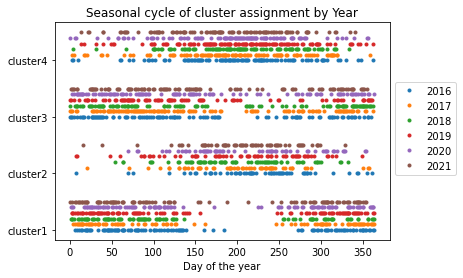

In [46]:
### Make a quick plot to show the index results

### plot each year
plt.plot(idx[0:365],'.',label='2016');
plt.plot(idx[365:365*2]+0.1,'.',label='2017');
plt.plot(idx[365*2:365*3]+0.2,'.',label='2018');
plt.plot(idx[365*3:365*4]+0.3,'.',label='2019');
plt.plot(idx[365*4:365*5]+0.4,'.',label='2020');
plt.plot(idx[365*5:365*6]+0.5,'.',label='2021');
#plt.legend(loc='best');
plt.legend(bbox_to_anchor=(1, 0.75), loc='upper left', ncol=1);
plt.yticks(np.arange(1,NO_CLUSTERS+1),labels=['cluster1','cluster2','cluster3','cluster4']);
plt.xlabel('Day of the year')
plt.title('Seasonal cycle of cluster assignment by Year');

**Summary:**

After clustering the data using 4 and 3 clusters I have determined that using 4 clusters shows a strong Spring signal in the data. I have also determined that using 3 clusters has a strong Spring and possible fall signal as well. Using the 3 cluster method Spring and Fall appear to be combined which makes it hard to determine if it would be considered a "true" spring cluster. Not knowing the seasonality of New Zealand makes it difficult to determine which method is better since spring can be seen clearly on the 3 and 4 cluster method. 

Using both 3 and 4 clusters the summer and winter are both very clealy defined and it could be possible that New Zealand doesn't really have a seasonal fall or spring given how far South they are. After doing a bit of research (https://www.newzealand.com/us/seasons-in-new-zealand/) it looks like the spring and fall temperatures are between 40F and 70F which is why the 3 clustering model fits well for Spring and fall. 

In summary my hypothesis is correct that a strong spring siganl would be seen using the 3 cluster method. However it is not easy to identify what is Spring and what is Fall using the 3 cluster method so I would say using the 4 cluster method shows a better Spring signal. 

# **Part 2: Linear Regression**


**Hypothesis 2: Dry temperature will have a stong positive correlation with the ENSO index (above .5) and there is statistical significance between dry temperature and the ENSO index**

# **STEP 1: Import Packages and Read in Data**

Will need to import packages as well as data again since data from above was altered and will give false results if we use it down here. 

**NOTE: Will need NZ_hourlydata_munged.csv and ENSOdata_2combine.csv data

**Import Packages**

In [18]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import numpy as np
import datetime
from google.colab import files
### import packages
import pandas as pd
import numpy as np
import datetime
import time
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from dateutil import relativedelta
import csv
from scipy import stats
from matplotlib import rcParams
from sklearn import linear_model
from sklearn import metrics
from google.colab import files

**Define Standardize function to use later**

In [19]:
### global functions (i.e., functions you want set for the entire notebook)

# function to standardize data, we'll steal this function from a previous notebook used in this class.
# recall that standardize the data = remove the mean, divide by the standard deviation.  
def standardize(raw_data):
    sample_mean = np.mean(raw_data)
    sample_std = np.std(raw_data)
    standardized_list = []
    for i in raw_data:
        standardized_list.append((i - sample_mean)/sample_std)
    return standardized_list

**Read in data**

In [20]:
### upload file NZ_hourlydata_munged.csv
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving NZ_hourlydata_munged.csv to NZ_hourlydata_munged (1).csv
User uploaded file "NZ_hourlydata_munged.csv" with length 7662698 bytes


In [21]:
### Read in your data (note: these include missing values)
dfNEW = pd.read_csv("NZ_hourlydata_munged.csv")

In [22]:
### upload file ENSOdata_2combine.csv
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving ENSOdata_2combine.csv to ENSOdata_2combine.csv
User uploaded file "ENSOdata_2combine.csv" with length 1017 bytes


In [23]:
### Read in your data
df2 = pd.read_csv("ENSOdata_2combine.csv")
### Print the Shape of the data frame and preview data
print(df2.shape)
df2

(73, 3)


,year,month,ENSO
0,2016,1,2.56
1,2016,2,2.11
2,2016,3,1.60
3,2016,4,1.05
4,2016,5,0.45
...,...,...,...
68,2021,9,-0.50
69,2021,10,-0.78
70,2021,11,-0.88
71,2021,12,-1.07


# **STEP 2: Munge Data**

Need to find the mean for each month, for each year, for all varialbes in New Zealand data (ENSO index is reported monthly so only 73 enteries for years 2016 to Jan2022, this is why we need the mean for each month for New Zealand data). 
Need to create a new dataframe with mean for each month of the year from New Zealand data and add ENSO index to the new dataframe. 

In [24]:
yy = []
mm = []
dd = []
for item in dfNEW['datetime'][:]:
  item = item.split('-')
  yy.append(item[0])
  mm.append(item[1])
  dd.append(item[2].split(' ')[0])

#Add these columns to 
dfNEW.insert(1, 'Year',yy)
dfNEW.insert(2, 'Month', mm)
# df.insert(3, 'Day', dd)

In [25]:
### Take the mean by month
mean_df = dfNEW.groupby(['Year','Month']).mean()

In [26]:
### convert to a numpy array

mean_df.to_numpy
#mean_df['RH'].values

<bound method DataFrame.to_numpy of             drytemp_F  dewtemp_F  prec_inch         RH  pres_mbar        wdir  \
Year Month                                                                      
2016 01     63.177807  55.723930        NaN  77.677807        NaN  211.076203   
     02     67.474527  58.152838        NaN  73.326783        NaN  192.983988   
     03     63.223051  54.157966        NaN  73.229831        NaN  166.644068   
     04     59.533981  51.416782        NaN  75.240638        NaN  170.984743   
     05     58.356858  50.376165        NaN  75.772304        NaN  229.653795   
...               ...        ...        ...        ...        ...         ...   
2021 09     52.852639  44.804661        NaN  74.876628        NaN  209.718986   
     10     56.695017  49.766777        NaN  78.665781        NaN  193.747508   
     11     60.259437  52.939602        NaN  78.006863        NaN  214.344544   
     12     63.632735  57.300067        NaN  80.799734        NaN  206.87

**Combine varialbes and ENSO index into one dataframe**

In [27]:

### add your met variables here
df2['RH']=mean_df['RH'].values
df2['drytemp_F']=mean_df['drytemp_F'].values
df2['dewtemp_F']=mean_df['dewtemp_F'].values
df2['wdir']=mean_df['wdir'].values
df2['wspd_mph']=mean_df['wspd_mph'].values
df2['wgust_mph']=mean_df['wgust_mph'].values
month=df2['month']
df2

,year,month,ENSO,RH,drytemp_F,dewtemp_F,wdir,wspd_mph,wgust_mph
0,2016,1,2.56,77.677807,63.177807,55.723930,211.076203,17.388369,34.582219
1,2016,2,2.11,73.326783,67.474527,58.152838,192.983988,16.569869,33.031295
2,2016,3,1.60,73.229831,63.223051,54.157966,166.644068,14.766102,33.935593
3,2016,4,1.05,75.240638,59.533981,51.416782,170.984743,13.569348,33.047157
4,2016,5,0.45,75.772304,58.356858,50.376165,229.653795,16.580559,33.828895
...,...,...,...,...,...,...,...,...,...
68,2021,9,-0.50,74.876628,52.852639,44.804661,209.718986,16.707334,35.285812
69,2021,10,-0.78,78.665781,56.695017,49.766777,193.747508,15.501661,35.798007
70,2021,11,-0.88,78.006863,60.259437,52.939602,214.344544,17.676047,34.087852
71,2021,12,-1.07,80.799734,63.632735,57.300067,206.872921,16.005323,31.976713


In [28]:
## Select variables of interest

included_cols = ['ENSO','drytemp_F','dewtemp_F','wdir','wspd_mph','wgust_mph','RH'] 

## convert to a numpy array for model input and leave out the time dimensions day & hour, and wind directions.
data = df2.loc[:,df2.columns.isin(list(included_cols))].to_numpy()

## check the shape of your data -- should be (6*365,7) (nyrs*ndays, variable)
print(f'Your data are now 73 observations over 7 variables: {np.shape(data)}')


Your data are now 73 observations over 7 variables: (73, 7)


**Using Quickplot to check data**

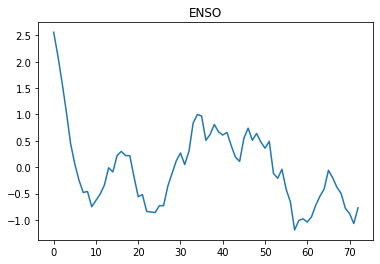

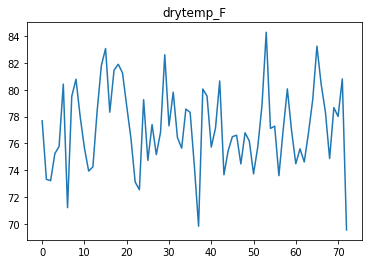

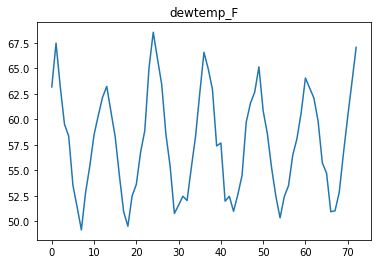

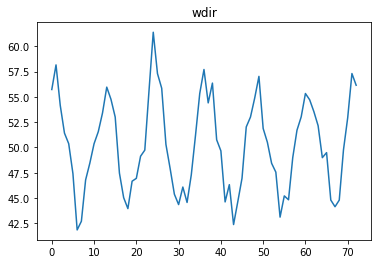

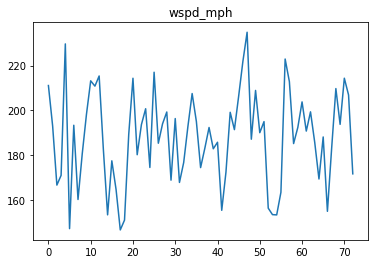

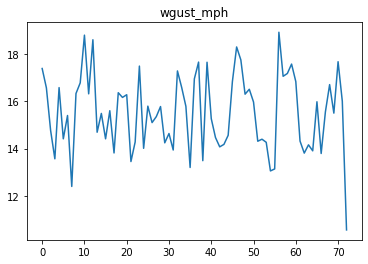

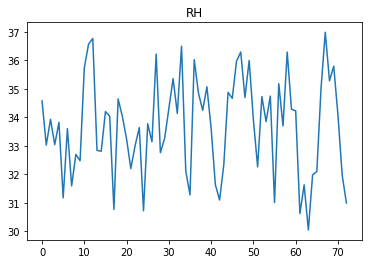

In [29]:
### option to check out quick plots of your data...
### say yes first time through - double check your input, ALWAYS.
quickplot = 'yes'
if quickplot == 'yes':
  ## Quick plots of your data
  for i in np.arange(0,np.shape(data)[1]):
    plt.plot(data[:,i]);
    plt.title(included_cols[i])
    plt.show()

**Rename varialbes to begin Linear Regression**

In [30]:
df2
temp_F=df2['drytemp_F']
dew_F=df2['dewtemp_F']
ENSO_index=df2['ENSO']
RH_per=df2['RH']
wgust=df2['wgust_mph']
wspd=df2['wspd_mph']
wdir=df2['wdir']


**Calculate the mean and Standard deviation for all variables**

In [31]:
from numpy.ma.core import shape

### calculate the mean and standard deviation of your data variables 
### I have commented out the print statements no need to do this step unless you want to check the values

##Dry Temp in Degree F
#print('Temp_F mean is:', df2['drytemp_F'])
temp_F_std=np.std(temp_F)
#print('Temp_F STD is:',(temp_F_std))
##Dew Temp in Degree F
#print('DewTemp_F mean is:', df2['dewtemp_F'])
dewtemp_F_std=np.std(dew_F)
#print('DewTemp_F STD is:',(dewtemp_F_std))
##Enso index
#print('ENSO mean is:', df2['ENSO'])
ENSO_index_std=np.std(ENSO_index)
#print('ENSO_index STD is:',(ENSO_index_std))
##RH in percent
#print('RH mean is:', df2['RH'])
RH_std=np.std(RH_per)
#print('RH_per STD is:',(RH_std))
##Wind Gust in MPH
#print('Wind gust mean is:', df2['wgust_mph'])
wgust_mph_std=np.std(wgust)
#print('wgust STD is:',(wgust_mph_std))
##Wind Speed in MPH
#print('Wind speed mean is:', df2['wspd_mph'])
wspd_mph_std=np.std(wspd)
#print('wspd STD is:',(wspd_mph_std))
##Wind direction in degree
#print('Wind direction mean is:', df2['wdir'])
wdir_std=np.std(wdir)
#print('Wind direction STD is:',(wdir_std))

**Detrend and Standardize Data**

**NOTE: mean should be 0 and STD 1.

In [32]:
### FIRST detrend - i.e., removing the linear slope
### I have commented out the slope values but think it is still important to print the mean and STD to ensure they are 0 and 1

## Temp_F
slope, intercept, r_value, p_value, std_err = stats.linregress(month,temp_F)
temp_F_dtrend=temp_F-(month*slope)
#print(f'slope temp_F: {np.round(slope,2)}')
## ENSO_index
slope, intercept, r_value, p_value, std_err = stats.linregress(month,ENSO_index)
ENSO_index_dtrend=ENSO_index-(month*slope)
#print(f'slope ENSO_index: {np.round(slope,2)}')
## Dewtemp_F
slope, intercept, r_value, p_value, std_err = stats.linregress(month,dew_F)
dew_F_dtrend=dew_F-(month*slope)
#print(f'slope dew_F: {np.round(slope,2)}')
## RH percent
slope, intercept, r_value, p_value, std_err = stats.linregress(month,RH_per)
RH_per_dtrend=RH_per-(month*slope)
#print(f'slope RH_per: {np.round(slope,2)}')
## Wind gust
slope, intercept, r_value, p_value, std_err = stats.linregress(month,wgust)
wgust_dtrend=wgust-(month*slope)
#print(f'slope wgust: {np.round(slope,2)}')
## Wind speed
slope, intercept, r_value, p_value, std_err = stats.linregress(month,wspd)
wspd_dtrend=wspd-(month*slope)
#print(f'slope wspd: {np.round(slope,2)}')
## Wind direction
slope, intercept, r_value, p_value, std_err = stats.linregress(month,wdir)
wdir_dtrend=wdir-(month*slope)
#print(f'slope wdir: {np.round(slope,2)}')

## standardize the data (i.e., remove the mean, divide by the standard deviation)
temp_F_stand = standardize(temp_F)
ENSO_index_stand = standardize(ENSO_index)
dew_F_stand = standardize(dew_F)
RH_per_stand = standardize(RH_per)
wgust_stand = standardize(wgust)
wspd_stand = standardize(wspd)
wdir_stand = standardize(wdir)
## check that data have a mean of 0 
print(f'mean temp_F: {np.round(np.mean(temp_F_stand),1)}')
print(f'mean ENSO_index: {np.round(np.mean(ENSO_index_stand),1)}')
print(f'mean dew_F: {np.round(np.mean(dew_F_stand),1)}')
print(f'mean RH_per: {np.round(np.mean(RH_per_stand),1)}')
print(f'mean wgust: {np.round(np.mean(wgust_stand),1)}')
print(f'mean wspd: {np.round(np.mean(wspd_stand),1)}')
print(f'mean wdir: {np.round(np.mean(wdir_stand),1)}')
##Check that data has standard deviation of 1
print(f'std  temp_F: {np.round(np.std(temp_F_stand),1)}')
print(f'std  ENSO_index: {np.round(np.std(ENSO_index_stand),1)}')
print(f'std  dew_F: {np.round(np.std(dew_F_stand),1)}')
print(f'std  RH_per: {np.round(np.std(RH_per_stand),1)}')
print(f'std  wgust: {np.round(np.std(wgust_stand),1)}')
print(f'std  wspd: {np.round(np.std(wspd_stand),1)}')
print(f'std  wdir: {np.round(np.std(wdir_stand),1)}')

mean temp_F: 0.0
mean ENSO_index: -0.0
mean dew_F: 0.0
mean RH_per: 0.0
mean wgust: -0.0
mean wspd: -0.0
mean wdir: -0.0
std  temp_F: 1.0
std  ENSO_index: 1.0
std  dew_F: 1.0
std  RH_per: 1.0
std  wgust: 1.0
std  wspd: 1.0
std  wdir: 1.0


# **STEP 3: Apply Data Sciene Method**

**Begin Linear Regression**

**Linear Regression for ENSO and Temperature**

In [33]:
## Print the values for the slope, y-intercept, r-value, variance explained and p-value.
## Using ENSO_index and temp_F

slope, intercept, r_value, p_value, std_err = stats.linregress(ENSO_index_stand,temp_F_stand)##EDIT stats.linregress(x,y)
print('Slope, a1:',round(slope,2))
print('Y-Intercept, a0:', round(intercept,2))
print('R_Value:', round(r_value,2))
print('Percent variance explained:',round((r_value**2)*100,1),'%')



Slope, a1: 0.07
Y-Intercept, a0: 0.0
R_Value: 0.07
Percent variance explained: 0.5 %


**T-Test for Temperature in Fahrenheit**

In [34]:
### Method #1: H0 (null hypothesis) correlation is 0  ## similar to Barnes Worked Problem 2.1
print('ASSESS SIGNIFICANCE OF REGRESSION METHOD #1')
print('Null Hypothesis: The true correlation is zero. ')
N=len(month)
dof=N-2
print("dof",dof)
tcrit=stats.t.ppf(0.975,N-2)  ## two-sided 95%
print('tcrit=',round(tcrit,2))
t=r_value*np.sqrt(N-2)/np.sqrt((1-r_value*r_value))
print('t=',round(t,2))
if t>tcrit:
  print('Since t=',round(t,2),'exceeds tcrit=',round(tcrit,2),' we can reject the null hypothesis')
elif t<tcrit:
  print('Since t=',round(t,2),'does not exceed tcrit=',round(tcrit,2),' we cannot reject the null hypothesis')

ASSESS SIGNIFICANCE OF REGRESSION METHOD #1
Null Hypothesis: The true correlation is zero. 
dof 71
tcrit= 1.99
t= 0.6
Since t= 0.6 does not exceed tcrit= 1.99  we cannot reject the null hypothesis


In [35]:
# Calculate the autocorrelation using numpy dot (direct calculation)
# (https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.dot.html)
tseries1=temp_F_stand
n=len(tseries1)
sigma=1
lag=1
alpha=np.dot(tseries1[0:-1*lag],tseries1[lag:])/(n-lag)/sigma**2 ## Barnes Chapter 2 Eq. 68 divided by the variance
print('lag',lag,'t_srf autocorrelation:',round(alpha,3))
## calculate N*
t_nstar=round((1-np.abs(alpha))/(1+np.abs(alpha))*n,0) ## Chapter 2 Barnes Eq. 88
print('#independent samples, N*: ',t_nstar) 

lag 1 t_srf autocorrelation: 0.81
#independent samples, N*:  8.0


**Linear Regression for ENSO and Wind Gust**

In [36]:
## Print the values for the slope, y-intercept, r-value, variance explained and p-value.
## Using ENSO_index and wgust

slope, intercept, r_value, p_value, std_err = stats.linregress(ENSO_index_stand,wgust_stand)##EDIT stats.linregress(x,y)
print('Slope, a1:',round(slope,2))
print('Y-Intercept, a0:', round(intercept,2))
print('R_Value:', round(r_value,2))
print('Percent variance explained:',round((r_value**2)*100,1),'%')


Slope, a1: 0.11
Y-Intercept, a0: -0.0
R_Value: 0.11
Percent variance explained: 1.1 %


**T-Test for Windgust in MPH**

In [37]:
### Method #1: H0 (null hypothesis) correlation is 0  ## similar to Barnes Worked Problem 2.1
print('ASSESS SIGNIFICANCE OF REGRESSION METHOD #1')
print('Null Hypothesis: The true correlation is zero. ')
N=len(month)
dof=N-2
print("dof",dof)
tcrit=stats.t.ppf(0.975,N-2)  ## two-sided 95%
print('tcrit=',round(tcrit,2))
t=r_value*np.sqrt(N-2)/np.sqrt((1-r_value*r_value))
print('t=',round(t,2))
if t>tcrit:
  print('Since t=',round(t,2),'exceeds tcrit=',round(tcrit,2),' we can reject the null hypothesis')
elif t<tcrit:
  print('Since t=',round(t,2),'does not exceed tcrit=',round(tcrit,2),' we cannot reject the null hypothesis')

ASSESS SIGNIFICANCE OF REGRESSION METHOD #1
Null Hypothesis: The true correlation is zero. 
dof 71
tcrit= 1.99
t= 0.9
Since t= 0.9 does not exceed tcrit= 1.99  we cannot reject the null hypothesis


**Using N* to do T-Test**

In [38]:
# Calculate the autocorrelation using numpy dot (direct calculation)
# (https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.dot.html)
tseries1=ENSO_index_stand
n=len(tseries1)
sigma=1
lag=1
alpha=np.dot(tseries1[0:-1*lag],tseries1[lag:])/(n-lag)/sigma**2 ## Barnes Chapter 2 Eq. 68 divided by the variance
print('lag',lag,'ENSO autocorrelation:',round(alpha,3))
## calculate N*
enso_nstar=round((1-np.abs(alpha))/(1+np.abs(alpha))*n,0) ## Chapter 2 Barnes Eq. 88
print('#independent samples, N*: ',enso_nstar)

lag 1 ENSO autocorrelation: 0.854
#independent samples, N*:  6.0


In [39]:
## here we will be conservative and use the smaller of the two N* values
Nstar=min(t_nstar,enso_nstar)
print(Nstar)

6.0


In [40]:
### Method #1: H0 (null hypothesis) correlation is 0  ## similar to Barnes Worked Problem 2.1
print('ASSESS SIGNIFICANCE OF REGRESSION METHOD #1')
print('Null Hypothesis: The true correlation is zero. ')
N=Nstar
dof=N-2
print("dof",dof)
tcrit=stats.t.ppf(0.975,N-2)  ## two-sided 95%
print('tcrit=',round(tcrit,2))
t=r_value*np.sqrt(N-2)/np.sqrt((1-r_value*r_value))
print('t=',round(t,2))
if t>tcrit:
  print('Since t=',round(t,2),'exceeds tcrit=',round(tcrit,2),' we can reject the null hypothesis')
elif t<tcrit:
  print('Since t=',round(t,2),'does not exceed tcrit=',round(tcrit,2),' we cannot reject the null hypothesis')

ASSESS SIGNIFICANCE OF REGRESSION METHOD #1
Null Hypothesis: The true correlation is zero. 
dof 4.0
tcrit= 2.78
t= 0.21
Since t= 0.21 does not exceed tcrit= 2.78  we cannot reject the null hypothesis


# **STEP 4: Present results visually**

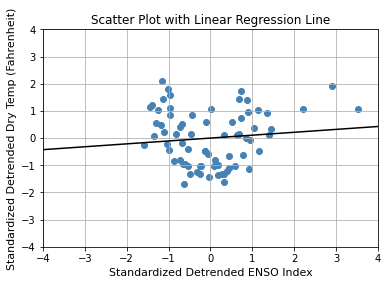

In [41]:
x=ENSO_index_stand ### EDIT THIS CELL (x, dependent variable)
y=temp_F_stand ### EDIT THIS CELL (y, independent variable)

fit_x = np.arange(-4,4.1,0.1);
fit_y = [];
for i in fit_x:
    fit_y.append(slope*i + intercept)
plt.scatter(ENSO_index_stand,temp_F_stand,c='steelblue');
plt.xlabel("Standardized Detrended ENSO Index",fontsize=11);
plt.ylabel("Standardized Detrended Dry Temp (Fahrenheit)",fontsize=11);
plt.xlim((-4,4));
plt.ylim((-4,4));
plt.grid();
plt.title("Scatter Plot with Linear Regression Line",fontsize=12);
plt.plot(fit_x,fit_y,c='black');


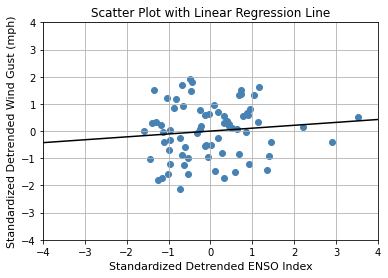

In [42]:
x=ENSO_index_stand ### EDIT THIS CELL (x, dependent variable)
y=wgust_stand ### EDIT THIS CELL (y, independent variable)

fit_x = np.arange(-4,4.1,0.1);
fit_y = [];
for i in fit_x:
    fit_y.append(slope*i + intercept)
plt.scatter(ENSO_index_stand,wgust_stand,c='steelblue');
plt.xlabel("Standardized Detrended ENSO Index",fontsize=11);
plt.ylabel("Standardized Detrended Wind Gust (mph)",fontsize=11);
plt.xlim((-4,4));
plt.ylim((-4,4));
plt.grid();
plt.title("Scatter Plot with Linear Regression Line",fontsize=12);
plt.plot(fit_x,fit_y,c='black');

**Summary**

After running all of the variables from the New Zealand data set through linear regression with ENSO index as my dependent variable I have determined that none of the variables have a strong positive correlation with the ENSO index. There are some variables that have a positive correlation or positive R-value but not a significant correlation. 

I printed and plotted the statistical values for temperature in Fahrenheit because my hypothesis was that temperature would have a strong positive correaltion of .5 or greater and after running a T-test I can't reject the null hypothesis that the true correlation is zero because my critical number is 1.99 and my T-value was .6. My hypothesis failed because the R-value is .07 which is positive but considered to have little if any correlation and I must reject the null hypothesis due to the low T-value.  

I printed and plotted the statistical values for Wind Gust in MPH because this was the only varialbe that I found that had the largest R-value of .11 and used the T-test to determine the true correlation which I had to reject the null hypothesis of the true correlation is zero because my critical number was 1.99 and my T-value was .9. Given the low r-value again it is positive but is still considered to have little if any correlation and I must reject the null hypothesis due to the low T-value.

In conclustion the variables provided from the New Zealand data set showed little if any correlation to ENSO events and are not statistically significant to predict an ENSO event. There were some excluded variables such as precipitation and pressure that may have had better statistics but it is hard to say given the results produced from the 6 other variables. 